In [2]:
!pip install -q torch

tcmalloc: large alloc 1073750016 bytes == 0x61184000 @  0x7fe00d62a2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [0]:
import numpy as np
from collections import Counter
import pickle as pkl
import random
import pdb
import pandas as pd
import string
import re
import unicodedata
import os
import time
import math

import spacy
from spacy.lang.en.stop_words import STOP_WORDS

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset
from torch.autograd import Variable
from torch.nn import functional

import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
%matplotlib inline

import logging

#specify SOS() and EOS(end of sentence)
#specify maximum vocabulary size = 50000
PAD_IDX = 2
UNK_IDX = 3
SOS_token = 0
EOS_token = 1
MAX_VOCAB_SIZE = 70000
MAX_LENGTH = 30

train_en = 'data/train.tok.en'
train_zh = 'data/train.tok.zh'
val_en = 'data/dev.tok.en'
val_zh = 'data/dev.tok.zh'


In [4]:
#user GPU if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
  print("Currently using GPU")

Currently using GPU


In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
folder_path = os.getcwd() + '/gdrive/My Drive/NLP/Project/'

Load Pre-Trained Embedding Matrix

In [0]:
def load_emb_matrix(language):
    #load fasttext word vectors
    words_to_load = MAX_VOCAB_SIZE
    if language == 'english':
      file = 'wiki-news-300d-1M-subword.vec'
    if language == 'chinese':
      file = 'cc.zh.300.vec'
    

    with open(folder_path + 'data/' + file) as f:
        #remove the first line
        firstLine = f.readline()
        loaded_embeddings = np.zeros((words_to_load + 4, 300))
        words2id = {}
        idx2words = {}
        #ordered_words = []
        for i, line in enumerate(f):
            if i >= words_to_load: 
                break
            s = line.split()
            loaded_embeddings[i + 4 , :] = np.asarray(s[1:])
            words2id['<SOS>'] = SOS_token
            words2id['<EOS>'] = EOS_token
            words2id['<pad>'] = PAD_IDX
            words2id['<unk>'] = UNK_IDX
            words2id[s[0]] = i + 4
            
            idx2words[0] = '<SOS>'
            idx2words[1] = '<EOS>'
            idx2words[2] = '<pad>'
            idx2words[3] = '<unk>'
            
            idx2words[i + 4] = s[0]
   

    return words2id,idx2words,loaded_embeddings

In [0]:
def generate_weights_matrix(idx2words,loaded_embeddings):
   
    matrix_len = len(idx2words)
    weights_matrix = np.zeros((matrix_len, 300))
    
    for key in idx2words.keys():
        try: 
            weights_matrix[key] = loaded_embeddings[key]
        except KeyError:
            weights_matrix[key] = np.random.normal(scale=0.6, size=(emb_dim, ))
    return weights_matrix

In [0]:
words2id_eng,idx2words_eng,loaded_embeddings_eng = load_emb_matrix('english')
words2id_zh,idx2words_zh,loaded_embeddings_zh = load_emb_matrix('chinese')

pkl.dump(words2id_eng, open(folder_path + 'data/words2id_eng.pkl', 'wb'))
pkl.dump(idx2words_eng, open(folder_path +'data/idx2words_eng.pkl', 'wb'))
pkl.dump(loaded_embeddings_eng, open(folder_path +'data/embedding_matrix_eng.pkl', 'wb'))

pkl.dump(words2id_zh, open(folder_path + 'data/words2id_zh.pkl', 'wb'))
pkl.dump(idx2words_zh, open(folder_path + 'data/idx2words_zh.pkl', 'wb'))
pkl.dump(loaded_embeddings_zh, open(folder_path +'data/embedding_matrix_zh.pkl', 'wb'))


In [0]:
weights_matrix_eng = generate_weights_matrix(idx2words_eng,loaded_embeddings_eng)
pkl.dump(weights_matrix_eng, open(folder_path + 'data/weights_matrix_eng.pkl', 'wb'))
weights_matrix_eng = torch.from_numpy(weights_matrix_eng).to(device)

weights_matrix_zh = generate_weights_matrix(idx2words_zh,loaded_embeddings_zh)
pkl.dump(weights_matrix_zh, open(folder_path + 'data/weights_matrix_zh.pkl', 'wb'))
weights_matrix_zh = torch.from_numpy(weights_matrix_zh).to(device)

In [0]:
words2id_eng = pkl.load(open(folder_path + "data/words2id_eng.pkl", "rb"))
idx2words_eng = pkl.load(open(folder_path +"data/idx2words_eng.pkl", "rb"))
loaded_embeddings_eng = pkl.load(open(folder_path +"data/embedding_matrix_eng.pkl", "rb"))
words2id_zh = pkl.load(open(folder_path + "data/words2id_zh.pkl", "rb"))
idx2words_zh = pkl.load(open(folder_path +"data/idx2words_zh.pkl", "rb"))
loaded_embeddings_zh = pkl.load(open(folder_path +"data/embedding_matrix_zh.pkl", "rb"))

weights_matrix_eng = pkl.load(open(folder_path +"data/weights_matrix_eng.pkl", "rb"))
weights_matrix_eng = torch.from_numpy(weights_matrix_eng).to(device)
weights_matrix_zh = pkl.load(open(folder_path +"data/weights_matrix_zh.pkl", "rb"))
weights_matrix_zh = torch.from_numpy(weights_matrix_zh).to(device)

Read Languages

In [0]:
#define a class of language
class Language:
    def __init__(self, name,word2index,index2word):
        self.name = name
        self.word2index = word2index
        #self.word2count = {}
        self.index2word = index2word
        self.n_words = len(word2index)



In [0]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters

def normalizeString(s):
    s = s.replace(r"&quot;","")
    s = s.replace(r"&apos;","'")
    s = unicodeToAscii(s.strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s
  
  
def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [0]:
#To read the data file we will split the file into lines, and then split lines into pairs. 

def readLanguages(input_lang,target_lang):
    print("\nReading lines...")

    # Read the file and split into lines
    input_lines = open(folder_path + input_lang, encoding='utf-8').\
        read().strip().split('\n')
    target_lines = open(folder_path + target_lang, encoding='utf-8').\
        read().strip().split('\n')

    # Split every line and normalize
    #for chinese input, strip the space at the begining and end of the sentence
    #for english output, use normalizeString function
    input_lines_norm = [l.strip() for l in input_lines]
    target_lines_norm = [normalizeString(l) for l in target_lines]
    
    #build pairs
    #drop pair if both zh and en are empty strings
    pairs = [[item[0],item[1]] for item in zip(input_lines_norm,target_lines_norm) if len(item[0])+len(item[1]) != 0]
    
    input_lines = Language("zh",words2id_zh,idx2words_zh)
    target_lines = Language("en",words2id_eng,idx2words_eng)

    return input_lines, target_lines, pairs

def prepareData(input_lang, target_lang):
    input_lang, output_lang, pairs = readLanguages(input_lang, target_lang)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")

    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    
    return input_lang, output_lang, pairs



Preparing Data
========

In [13]:
train_input_lang, train_output_lang, train_pairs = prepareData(train_zh, train_en)
print("print a random pair of training pairs:")
print(random.choice(train_pairs))



val_input_lang, val_output_lang, val_pairs = prepareData(val_zh, val_en)
print("print a random pair of validation pairs:")
print(random.choice(val_pairs))


# pkl.dump(train_input, open(folder_path +'data/train_input.pkl', 'wb'))
# pkl.dump(train_output, open(folder_path +'data/train_output.pkl', 'wb'))
# pkl.dump(train_pairs, open(folder_path +'data/train_pairs.pkl', 'wb'))
# pkl.dump(val_input, open(folder_path +'data/val_input.pkl', 'wb'))
# pkl.dump(val_output, open(folder_path +'data/val_output.pkl', 'wb'))
# pkl.dump(val_pairs, open(folder_path +'data/val_pairs.pkl', 'wb'))


Reading lines...
Read 213237 sentence pairs
Trimmed to 156070 sentence pairs
Counting words...
zh 70004
en 70004
print a random pair of training pairs:
['我们 后来 还有 一套 智力 棋 游戏   置 色子 来 玩 的', 'And then we had a snakes and ladders game where you throw dice .']

Reading lines...
Read 1261 sentence pairs
Trimmed to 848 sentence pairs
Counting words...
zh 70004
en 70004
print a random pair of validation pairs:
['她 也 开始 始自 自己 亲手 清洗 洗照片 照片   直到   她 意识 到 她 自己 清洗 其实 对照 照片 造成 了 更多 损害', 'She had started hand cleaning them herself and stopped when she realized she was doing more damage .']


In [0]:
# train_pairs =  pkl.load(open(folder_path +'data/train_pairs.pkl', "rb"))
# val_pairs =  pkl.load(open(folder_path +'data/val_pairs.pkl', "rb"))

## Build DataLoader for minibatch

In [0]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] if word in lang.word2index else UNK_IDX for word in sentence.split(' ')] + [EOS_token]

In [0]:
BATCH_SIZE = 32

class VocabDataset(Dataset):
    """
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, pairs,input_language, output_language):
        """
        @param pairs: pairs of input and target sentences(raw text sentences)
        @param input_language: Class Lang of input languages (zh in this case)
        @param output_language: Class Lang of output languages (en in this case)

        """
        self.pairs = pairs
        self.inputs = [pair[0] for pair in pairs]
        self.input_lang = input_language
        self.output_lang = output_language
        self.outputs = [pair[1] for pair in pairs]
        
        
        #assert self.input_lang == self.target_lang
       
    def __len__(self):
         return len(self.pairs)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        #turn raw text sentecens into indices
        input_ = indexesFromSentence(self.input_lang, self.inputs[key])
        output = indexesFromSentence(self.output_lang, self.outputs[key])
        
        #print both the length of the source sequence and the target sequence
        return [input_,len(input_),output,len(output)]
    
    
    def __gettext__(self,key):
      return [self.inputs[key],self.outputs[key]]

def vocab_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    input_data_list = []
    output_data_list = []
   
    
    for datum in batch:
      input_data_list.append(datum[0])
      output_data_list.append(datum[2])
      
      
    # Zip into pairs, sort by length (descending), unzip
    seq_pairs = sorted(zip(input_data_list, output_data_list), key=lambda p: len(p[0]), reverse=True)
    input_seqs, output_seqs = zip(*seq_pairs)
    
    #store the length of the sequences 
    input_data_len = [len(p) for p in input_seqs]
    output_data_len = [len(p) for p in output_seqs]
    
    #padding
    padded_vec_input = [np.pad(np.array(p),
                                 pad_width=((0,MAX_LENGTH-len(p))),
                                 mode="constant", constant_values=0) for p in input_seqs]
        
    padded_vec_output = [np.pad(np.array(p),
                                 pad_width=((0,MAX_LENGTH-len(p))),
                                 mode="constant", constant_values=0) for p in output_seqs]      
    
    
    input_var = Variable(torch.LongTensor(padded_vec_input))
    output_var = Variable(torch.LongTensor(padded_vec_output))
    input_data_len = Variable(torch.LongTensor(input_data_len))
    output_data_len = Variable(torch.LongTensor(output_data_len))
    
    
    return [input_var,input_data_len,output_var,output_data_len]
   

   

In [0]:
# Build train and valid dataloaders

train_dataset = VocabDataset(train_pairs,train_input_lang, train_output_lang)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True,
                                           drop_last = True)


val_dataset = VocabDataset(val_pairs,val_input_lang,val_output_lang)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=False,
                                         drop_last = True)



Building Neural Networks (Encoder & Decoder)
-----------

The Encoder
-----------

The encoder of a seq2seq network is a RNN that outputs some value for
every word from the input sentence. For every input word the encoder
outputs a vector and a hidden state, and uses the hidden state for the
next input word.

In [0]:
class EncoderRNN(nn.Module):
    def __init__(self, weights_matrix, input_size, hidden_size,n_layers=1):
        super(EncoderRNN, self).__init__()
     
        
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.n_layers = n_layers
        self.batch_size = BATCH_SIZE
        self.num_embeddings, self.embedding_dim = weights_matrix.size()
        
        self.embedding = nn.Embedding(self.num_embeddings, self.embedding_dim).to(device)
        self.embedding.weight.data.copy_(weights_matrix)
        self.embedding.weight.requires_grad = False

        
        self.gru = nn.GRU(self.embedding_dim, hidden_size, n_layers, bidirectional=True)
        

    def forward(self, input_seqs, input_len, hidden=None):

       
        embedded = self.embedding(input_seqs)
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_len)
        output, hidden = self.gru(packed, hidden)

        output, output_len = torch.nn.utils.rnn.pad_packed_sequence(output)
        output = output[:, :, :self.hidden_size] + output[:, : ,self.hidden_size:]
        
        return output,hidden
      

   

Decoder w/o Attention
------------------------
In the simplest seq2seq decoder we use only last output of the encoder. This last output is sometimes called the context vector as it encodes context from the entire sequence. This context vector is used as the initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and hidden state. The initial input token is the start-of-string <SOS> token, and the first hidden state is the context vector (the encoder's last hidden state).

In [0]:
class DecoderRNN(nn.Module):
    def __init__(self, weights_matrix, hidden_size, output_size,n_layers=1):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.num_embeddings, self.embedding_dim = weights_matrix.size()
        
        #self.embedding = nn.Embedding(output_size, hidden_size)
        self.embedding = nn.Embedding(self.num_embeddings, self.embedding_dim).to(device)
        self.embedding.weight.data.copy_(weights_matrix)
        self.embedding.weight.requires_grad = False
        
        self.gru1 = nn.GRU(self.embedding_dim, hidden_size,n_layers)
        self.gru2 = nn.GRU(hidden_size, hidden_size,n_layers)
        
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_seq, hidden):
        
        embedded = self.embedding(input_seq) # dim = Batch_Size x embedding_dim
        embedded = embedded.view(1, embedded.size(0), self.embedding_dim) # S=1 x Batch_Size x embedding_dim
        
        rnn_output, hidden = self.gru1(embedded, hidden)
        output = F.relu(rnn_output)
        
        output, hidden = self.gru2(output, hidden)
        output = self.softmax(self.out(output[0]))
        
        return output,hidden



    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size).to(device)

Training
========

In [0]:
#record the run time
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [0]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [0]:
def sequence_mask(sequence_length, max_len=None):
    if max_len is None:
        max_len = sequence_length.data.max()
    batch_size = BATCH_SIZE
    seq_range = torch.arange(0, max_len).long()
    seq_range_expand = seq_range.unsqueeze(0).expand(batch_size, max_len)
    seq_range_expand = Variable(seq_range_expand)
    
    seq_range_expand = seq_range_expand.to(device)
    seq_length_expand = (sequence_length.unsqueeze(1)
                         .expand_as(seq_range_expand))
    return seq_range_expand < seq_length_expand


def masked_cross_entropy(logits, target, length):
    length = Variable(torch.LongTensor(length)).to(device)

    """
    Args:
        logits: A Variable containing a FloatTensor of size
            (batch, max_len, num_classes) which contains the
            unnormalized probability for each class.
        target: A Variable containing a LongTensor of size
            (batch, max_len) which contains the index of the true
            class for each corresponding step.
        length: A Variable containing a LongTensor of size (batch,)
            which contains the length of each data in a batch.
    Returns:
        loss: An average loss value masked by the length.
    """
    
    # logits_flat: (batch * max_len, num_classes)
    logits_flat = logits.view(-1, logits.size(-1))
    # log_probs_flat: (batch * max_len, num_classes)
    log_probs_flat = F.log_softmax(logits_flat,dim=1)
    
    # target_flat: (batch * max_len, 1)
    target_flat = target.view(-1, 1)
    
    # losses_flat: (batch * max_len, 1)
    losses_flat = -torch.gather(log_probs_flat, dim=1, index=target_flat)
    # losses: (batch, max_len)
    losses = losses_flat.view(*target.size())
    # mask: (batch, max_len)
    mask = sequence_mask(sequence_length=length, max_len=target.size(1))
    losses = losses * mask.float()
    loss = losses.sum() / length.float().sum()
    return loss

##Train Model

In [0]:
hidden_size = 500

encoder1 = EncoderRNN(weights_matrix_zh, train_input_lang.n_words, hidden_size,n_layers = 3).to(device)
decoder1 = DecoderRNN(weights_matrix_eng, hidden_size, train_output_lang.n_words,n_layers = 3).to(device)

Testing small batches with teaching force

In [0]:
encoder_optimizer = optim.SGD(encoder1.parameters(), lr=0.001)
decoder_optimizer = optim.SGD(decoder1.parameters(), lr=0.001)
criterion = nn.NLLLoss()
teacher_forcing_ratio = 1
learning_rate = 0.0001


for i, (input_var,input_data_len,output_var,output_data_len) in enumerate(train_loader):

  input_batch = input_var.transpose(0,1).to(device)
  output_batch = output_var.transpose(0,1).to(device)

  loss = train(input_batch,input_data_len,output_batch,output_data_len, encoder1,
                 decoder1, encoder_optimizer, decoder_optimizer, criterion,teacher_forcing_ratio)
  print(loss)
  


In [0]:
encoder_optimizer = optim.SGD(encoder1.parameters(), lr=0.1)
decoder_optimizer = optim.SGD(decoder1.parameters(), lr=0.1)
criterion = nn.NLLLoss()

for l, (input_var,input_data_len,output_var,output_data_len) in enumerate(train_loader):
    input_batch = input_var.transpose(0,1).to(device)
    output_batch = output_var.transpose(0,1).to(device)
    encoder_outputs, encoder_hidden = encoder1(input_batch, input_data_len, None)
  
    max_target_length = MAX_LENGTH
    # Prepare decoder input and outputs
    decoder_input = Variable(torch.LongTensor([SOS_token] * BATCH_SIZE)).to(device)
    decoder_hidden = encoder_hidden[:decoder1.n_layers] # Use last (forward) hidden state from encoder
    all_decoder_outputs = Variable(torch.zeros(max_target_length, BATCH_SIZE, decoder1.output_size)).to(device)
 
  
    # Run through decoder one time step at a time
    for t in range(max_target_length):
        decoder_output,decoder_hidden = decoder1(
        decoder_input, decoder_hidden
    )
        
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze().detach()  # detach from history as input
        all_decoder_outputs[t] = decoder_output # Store this step's outputs
    
    # Test masked cross entropy loss
    loss = masked_cross_entropy(
        all_decoder_outputs.transpose(0, 1).contiguous(),
        output_batch.transpose(0, 1).contiguous(),
        output_data_len)

    if l >= 20:
        break
  


In [0]:
loss

tensor(10.8263, device='cuda:0', grad_fn=<DivBackward1>)

Testing without teaching force

In [0]:
encoder_optimizer = optim.SGD(encoder1.parameters(), lr=0.1)
decoder_optimizer = optim.SGD(decoder1.parameters(), lr=0.1)
criterion = nn.NLLLoss()

for l, (input_var,input_data_len,output_var,output_data_len) in enumerate(train_loader):
    input_batch = input_var.transpose(0,1).to(device)
    output_batch = output_var.transpose(0,1).to(device)
    encoder_outputs, encoder_hidden = encoder1(input_batch, input_data_len, None)
  
    max_target_length = MAX_LENGTH
    # Prepare decoder input and outputs
    decoder_input = Variable(torch.LongTensor([SOS_token] * BATCH_SIZE)).to(device)
    decoder_hidden = encoder_hidden[:decoder1.n_layers] # Use last (forward) hidden state from encoder
    all_decoder_outputs = Variable(torch.zeros(max_target_length, BATCH_SIZE, decoder1.output_size)).to(device)
    loss = 0
  
    # Run through decoder one time step at a time
    for t in range(max_target_length):
        decoder_output, decoder_hidden = decoder1(
        decoder_input, decoder_hidden
    )
        
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze().detach()  # detach from history as input
        all_decoder_outputs[t] = decoder_output # Store this step's outputs
    
    # Test masked cross entropy loss
    loss = masked_cross_entropy(
        all_decoder_outputs.transpose(0, 1).contiguous(),
        output_batch.transpose(0, 1).contiguous(),
        output_data_len)

    if l >= 1:
        break

  


In [0]:
loss

tensor(10.8258, device='cuda:0', grad_fn=<DivBackward1>)

In [0]:
#the train function is now taking a batch at a time
def train(input_batch, input_lengths, output_batch, output_lengths, encoder, decoder, encoder_optimizer, 
          decoder_optimizer, criterion, teacher_forcing_ratio, max_length=MAX_LENGTH, if_attention = False):
  
    # Zero gradients of both optimizers
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    encoder_outputs, encoder_hidden = encoder(input_batch, input_lengths, None)
  

    # Prepare decoder input and outputs
    decoder_input = Variable(torch.LongTensor([SOS_token] * BATCH_SIZE)).to(device)
    decoder_hidden = encoder_hidden[:decoder.n_layers] # Use last (forward) hidden state from encoder
    all_decoder_outputs = Variable(torch.zeros(max_length, BATCH_SIZE, decoder.output_size)).to(device)
    
    # Run through decoder one time step at a time
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    # Teacher forcing: Feed the target as the next input
    if use_teacher_forcing:
        # Run through decoder one time step at a time
        for di in range(max_length):
            if if_attention == True:
                decoder_output, decoder_hidden, decoder_attn = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
            else:

                decoder_output, decoder_hidden = decoder(
                    decoder_input, decoder_hidden)
                
            all_decoder_outputs[di] = decoder_output # Store this step's outputs
            decoder_input = output_batch[di] # Next input is current target

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(max_length):
            if if_attention == True:
                decoder_output, decoder_hidden, decoder_attn = decoder(
                  decoder_input, decoder_hidden, encoder_outputs)
            else:

                decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
                
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input
            all_decoder_outputs[di] = decoder_output

    
    # Loss calculation and backpropagation
    loss = masked_cross_entropy(
            all_decoder_outputs.transpose(0, 1).contiguous(), # -> batch x seq
            output_batch.transpose(0, 1).contiguous(), # -> batch x seq
            output_lengths)    

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()
      


    return loss.item()
 

In [0]:
def trainIters(encoder, decoder, encoder_optimizer, decoder_optimizer, n_iters, teacher_forcing_ratio, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    criterion = nn.NLLLoss()
    iters = 0
    
    while iters <= n_iters:
      
      
      
      for i, (input_var,input_data_len,output_var,output_data_len) in enumerate(train_loader):
        iters += 1
        input_batch = input_var.transpose(0,1).to(device)
        output_batch = output_var.transpose(0,1).to(device)
        
        loss = train(input_batch.long().to(device),input_data_len,output_batch.long().to(device),output_data_len, encoder,
                       decoder, encoder_optimizer, decoder_optimizer, criterion,teacher_forcing_ratio)
       
        
        # Keep track of loss
        print_loss_total += loss
        plot_loss_total += loss


        if iters % print_every == 0:

          print_loss_avg = print_loss_total / print_every
          print_loss_total = 0
          print('%s (%d %d%%) %.4f' % (timeSince(start, iters / n_iters),
                                           iters, iters / n_iters * 100, print_loss_avg))
          
          torch.save(encoder.state_dict(), folder_path + 'encoder_1211.pt')
          torch.save(decoder.state_dict(), folder_path + 'decoder_1211.pt')

        if iters % plot_every == 0:
          plot_loss_avg = plot_loss_total / plot_every
          plot_losses.append(plot_loss_avg)
          plot_loss_total = 0

    showPlot(plot_losses)

Training model on sample data, without attention mechanism. Using pre-trained word embedding for both languages, and not updating the weights

In [0]:
# Configure models
hidden_size = 500
layers = 2
teacher_forcing_ratio = 0.5
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iters = 10000

# Initialize models
encoder = EncoderRNN(weights_matrix_zh, train_input_lang.n_words, hidden_size, n_layers = layers).to(device)
decoder = DecoderRNN(weights_matrix_eng, hidden_size, train_output_lang.n_words, n_layers = layers).to(device)

# Initialize optimizers and criterion
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()



1m 11s (- 117m 56s) (100 1%) 10.8178
2m 22s (- 116m 30s) (200 2%) 10.7931
3m 33s (- 114m 56s) (300 3%) 10.7411
4m 43s (- 113m 27s) (400 4%) 10.6561
5m 54s (- 112m 11s) (500 5%) 10.5224
7m 4s (- 110m 51s) (600 6%) 10.2594
8m 14s (- 109m 32s) (700 7%) 9.5737
9m 25s (- 108m 19s) (800 8%) 9.3512
10m 35s (- 107m 6s) (900 9%) 9.1628
11m 45s (- 105m 48s) (1000 10%) 8.9847
12m 54s (- 104m 29s) (1100 11%) 8.6063
14m 4s (- 103m 15s) (1200 12%) 8.1901
15m 14s (- 102m 1s) (1300 13%) 8.1998
16m 25s (- 100m 51s) (1400 14%) 8.0658
17m 35s (- 99m 40s) (1500 15%) 8.1448
18m 45s (- 98m 30s) (1600 16%) 8.0000
19m 55s (- 97m 18s) (1700 17%) 7.7528
21m 5s (- 96m 6s) (1800 18%) 7.7712
22m 15s (- 94m 54s) (1900 19%) 7.7044
23m 25s (- 93m 43s) (2000 20%) 7.5315
24m 36s (- 92m 32s) (2100 21%) 7.5286
25m 45s (- 91m 21s) (2200 22%) 7.4363
26m 56s (- 90m 10s) (2300 23%) 7.3637
28m 6s (- 89m 0s) (2400 24%) 7.3265
29m 16s (- 87m 49s) (2500 25%) 7.2505
30m 26s (- 86m 38s) (2600 26%) 7.1977
31m 36s (- 85m 27s) (2700 

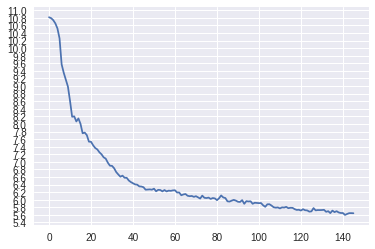

In [0]:
trainIters(encoder, decoder, encoder_optimizer, decoder_optimizer, n_iters, teacher_forcing_ratio, print_every=100, plot_every=100, learning_rate=learning_rate)

In [0]:
torch.save(encoder.state_dict(), folder_path + 'encoder2.pt')
torch.save(decoder.state_dict(), folder_path + 'decoder2.pt')

Training Model: Nov. 28th

In [0]:
# Configure models
hidden_size = 500
layers = 2
teacher_forcing_ratio = 0.5
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iters = 10000

encoder2 = EncoderRNN(weights_matrix_zh, train_input_lang.n_words, hidden_size, n_layers = layers).to(device)
decoder2 = DecoderRNN(weights_matrix_eng, hidden_size, train_output_lang.n_words, n_layers = layers).to(device)

encoder_optimizer = optim.Adam(encoder2.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(decoder2.parameters(), lr=learning_rate)

encoder2.load_state_dict(torch.load(folder_path + "encoder2.pt"))
decoder2.load_state_dict(torch.load(folder_path +"decoder2.pt"))

1m 10s (- 115m 59s) (100 1%) 5.5975
2m 20s (- 114m 32s) (200 2%) 5.5513
3m 30s (- 113m 15s) (300 3%) 5.5141
4m 39s (- 111m 56s) (400 4%) 5.5060
5m 49s (- 110m 49s) (500 5%) 5.5657
7m 0s (- 109m 42s) (600 6%) 5.5435
8m 10s (- 108m 35s) (700 7%) 5.5424
9m 20s (- 107m 23s) (800 8%) 5.4890
10m 30s (- 106m 17s) (900 9%) 5.5470
11m 41s (- 105m 11s) (1000 10%) 5.5296
12m 51s (- 104m 5s) (1100 11%) 5.5616
14m 2s (- 102m 57s) (1200 12%) 5.5474
15m 12s (- 101m 48s) (1300 13%) 5.5131
16m 23s (- 100m 39s) (1400 14%) 5.5158
17m 33s (- 99m 29s) (1500 15%) 5.4853
18m 43s (- 98m 20s) (1600 16%) 5.6163
19m 54s (- 97m 9s) (1700 17%) 5.5137
21m 4s (- 96m 1s) (1800 18%) 5.5727
22m 15s (- 94m 51s) (1900 19%) 5.5330
23m 25s (- 93m 41s) (2000 20%) 5.5151
24m 35s (- 92m 32s) (2100 21%) 5.6084
25m 46s (- 91m 22s) (2200 22%) 5.5317
26m 56s (- 90m 12s) (2300 23%) 5.5578
28m 6s (- 89m 1s) (2400 24%) 5.5048
29m 17s (- 87m 52s) (2500 25%) 5.5931
30m 27s (- 86m 41s) (2600 26%) 5.5273
31m 38s (- 85m 32s) (2700 27%) 5

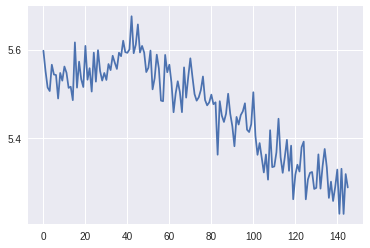

In [0]:
trainIters(encoder2, decoder2, encoder_optimizer, decoder_optimizer, n_iters, teacher_forcing_ratio, print_every=100, plot_every=100, learning_rate=learning_rate)

In [0]:
torch.save(encoder2.state_dict(), folder_path + 'encoder3.pt')
torch.save(decoder2.state_dict(), folder_path + 'decoder3.pt')

Training Model: Nov 30th

In [0]:
# Configure models
hidden_size = 500
layers = 2
teacher_forcing_ratio = 0.5
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iters = 10000

encoder3 = EncoderRNN(weights_matrix_zh, train_input_lang.n_words, hidden_size, n_layers = layers).to(device)
decoder3 = DecoderRNN(weights_matrix_eng, hidden_size, train_output_lang.n_words, n_layers = layers).to(device)

encoder_optimizer = optim.Adam(encoder3.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(decoder3.parameters(), lr=learning_rate * decoder_learning_ratio)

encoder3.load_state_dict(torch.load(folder_path + "encoder3.pt"))
decoder3.load_state_dict(torch.load(folder_path +"decoder3.pt"))

1m 12s (- 119m 54s) (100 1%) 5.3020
2m 25s (- 118m 30s) (200 2%) 5.2259
3m 37s (- 117m 12s) (300 3%) 5.2173
4m 49s (- 115m 54s) (400 4%) 5.1294
6m 2s (- 114m 41s) (500 5%) 5.1952
7m 14s (- 113m 29s) (600 6%) 5.2293
8m 27s (- 112m 19s) (700 7%) 5.2073
9m 40s (- 111m 10s) (800 8%) 5.2156
10m 52s (- 109m 58s) (900 9%) 5.2079
12m 5s (- 108m 47s) (1000 10%) 5.1818
13m 17s (- 107m 34s) (1100 11%) 5.1819
14m 30s (- 106m 21s) (1200 12%) 5.1847
15m 42s (- 105m 9s) (1300 13%) 5.1598
16m 55s (- 103m 58s) (1400 14%) 5.2264
18m 8s (- 102m 47s) (1500 15%) 5.1932
19m 20s (- 101m 33s) (1600 16%) 5.0898
20m 33s (- 100m 21s) (1700 17%) 5.1719
21m 45s (- 99m 8s) (1800 18%) 5.1086
22m 58s (- 97m 56s) (1900 19%) 5.1683
24m 11s (- 96m 44s) (2000 20%) 5.2070
25m 23s (- 95m 30s) (2100 21%) 5.1358
26m 35s (- 94m 17s) (2200 22%) 5.1514
27m 47s (- 93m 4s) (2300 23%) 5.0986
29m 0s (- 91m 51s) (2400 24%) 5.1812
30m 13s (- 90m 39s) (2500 25%) 5.1921
31m 25s (- 89m 26s) (2600 26%) 5.1287
32m 38s (- 88m 14s) (2700 27

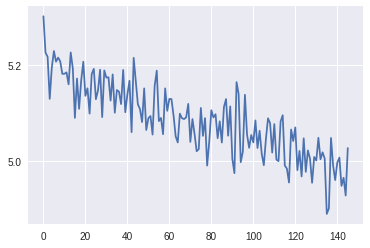

In [0]:
trainIters(encoder3, decoder3, encoder_optimizer,decoder_optimizer,  n_iters, teacher_forcing_ratio, print_every=100, plot_every=100, learning_rate=learning_rate)

In [0]:
torch.save(encoder3.state_dict(), folder_path + 'encoder3.pt')
torch.save(decoder3.state_dict(), folder_path + 'decoder3.pt')

1m 13s (- 120m 44s) (100 1%) 4.9841
2m 26s (- 119m 21s) (200 2%) 4.9753
3m 39s (- 118m 3s) (300 3%) 4.9653
4m 51s (- 116m 41s) (400 4%) 4.9541
6m 4s (- 115m 29s) (500 5%) 4.9803
7m 17s (- 114m 15s) (600 6%) 4.9509
8m 30s (- 112m 59s) (700 7%) 4.9517
9m 42s (- 111m 42s) (800 8%) 4.9471
10m 55s (- 110m 29s) (900 9%) 5.0089
12m 8s (- 109m 13s) (1000 10%) 4.9203
13m 20s (- 107m 59s) (1100 11%) 4.9020
14m 32s (- 106m 41s) (1200 12%) 4.9097
15m 44s (- 105m 22s) (1300 13%) 4.9214
16m 56s (- 104m 3s) (1400 14%) 4.9448
18m 8s (- 102m 47s) (1500 15%) 4.9365
19m 20s (- 101m 33s) (1600 16%) 4.9928
20m 32s (- 100m 19s) (1700 17%) 4.9277
21m 45s (- 99m 5s) (1800 18%) 4.8891
22m 56s (- 97m 49s) (1900 19%) 4.9300
24m 8s (- 96m 35s) (2000 20%) 4.8954
25m 20s (- 95m 20s) (2100 21%) 4.8914
26m 32s (- 94m 6s) (2200 22%) 4.9192
27m 44s (- 92m 52s) (2300 23%) 4.9777
28m 56s (- 91m 39s) (2400 24%) 5.0269
30m 8s (- 90m 26s) (2500 25%) 4.9145
31m 20s (- 89m 13s) (2600 26%) 4.9308
32m 33s (- 88m 0s) (2700 27%) 

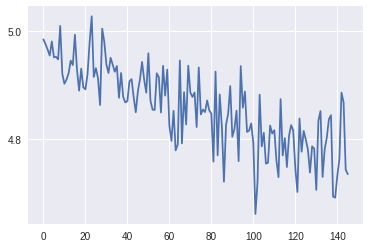

In [0]:
trainIters(encoder3, decoder3, encoder_optimizer, decoder_optimizer, n_iters, print_every=100, plot_every=100, learning_rate=learning_rate)

Continue training model. Dec 1st

In [0]:
# Configure models
hidden_size = 500
layers = 2
teacher_forcing_ratio = 0.5
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iters = 10000

encoder3 = EncoderRNN(weights_matrix_zh, train_input_lang.n_words, hidden_size, n_layers = layers).to(device)
decoder3 = DecoderRNN(weights_matrix_eng, hidden_size, train_output_lang.n_words, n_layers = layers).to(device)

encoder_optimizer = optim.SGD(encoder3.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(decoder3.parameters(), lr=learning_rate * decoder_learning_ratio)

encoder3.load_state_dict(torch.load(folder_path + "encoder3.pt"))
decoder3.load_state_dict(torch.load(folder_path +"decoder3.pt"))

1m 12s (- 118m 58s) (100 1%) 4.9586
2m 24s (- 117m 39s) (200 2%) 4.8956
3m 35s (- 116m 19s) (300 3%) 4.9088
4m 47s (- 115m 8s) (400 4%) 4.8906
5m 59s (- 113m 52s) (500 5%) 4.8654
7m 11s (- 112m 41s) (600 6%) 4.8978
8m 23s (- 111m 29s) (700 7%) 4.9147
9m 35s (- 110m 15s) (800 8%) 4.8580
10m 47s (- 109m 3s) (900 9%) 4.8884
11m 58s (- 107m 50s) (1000 10%) 4.8816
13m 11s (- 106m 40s) (1100 11%) 4.9097
14m 22s (- 105m 28s) (1200 12%) 4.9004
15m 34s (- 104m 14s) (1300 13%) 4.8182
16m 46s (- 103m 2s) (1400 14%) 4.9141
17m 58s (- 101m 49s) (1500 15%) 4.7952
19m 10s (- 100m 38s) (1600 16%) 4.8387
20m 22s (- 99m 28s) (1700 17%) 4.8767
21m 34s (- 98m 18s) (1800 18%) 4.8882
22m 46s (- 97m 6s) (1900 19%) 4.8499
23m 58s (- 95m 54s) (2000 20%) 4.8682
25m 10s (- 94m 42s) (2100 21%) 4.7994
26m 22s (- 93m 31s) (2200 22%) 4.8932
27m 34s (- 92m 20s) (2300 23%) 4.9030
28m 47s (- 91m 10s) (2400 24%) 4.9433
29m 59s (- 89m 59s) (2500 25%) 4.9439
31m 12s (- 88m 48s) (2600 26%) 4.8829
32m 24s (- 87m 37s) (2700 

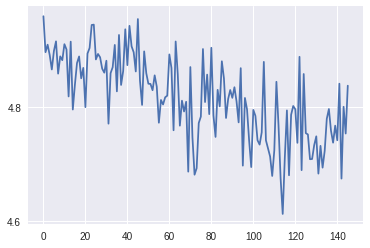

In [0]:
trainIters(encoder3, decoder3, encoder_optimizer, decoder_optimizer, n_iters, teacher_forcing_ratio, print_every=100, plot_every=100, learning_rate=learning_rate)

In [0]:
torch.save(encoder3.state_dict(), folder_path + 'encoder3.pt')
torch.save(decoder3.state_dict(), folder_path + 'decoder3.pt')

1m 12s (- 119m 48s) (100 1%) 4.7865
2m 25s (- 118m 40s) (200 2%) 4.8362
3m 37s (- 117m 24s) (300 3%) 4.7275
4m 50s (- 116m 13s) (400 4%) 4.7368
6m 2s (- 114m 52s) (500 5%) 4.6420
7m 15s (- 113m 39s) (600 6%) 4.7316
8m 28s (- 112m 29s) (700 7%) 4.7704
9m 40s (- 111m 18s) (800 8%) 4.7671
10m 53s (- 110m 4s) (900 9%) 4.7138
12m 5s (- 108m 48s) (1000 10%) 4.6540
13m 18s (- 107m 38s) (1100 11%) 4.8000
14m 30s (- 106m 22s) (1200 12%) 4.6196
15m 42s (- 105m 9s) (1300 13%) 4.6555
16m 54s (- 103m 54s) (1400 14%) 4.6349
18m 7s (- 102m 40s) (1500 15%) 4.6567
19m 19s (- 101m 26s) (1600 16%) 4.6454
20m 31s (- 100m 14s) (1700 17%) 4.7161
21m 43s (- 99m 0s) (1800 18%) 4.6275
22m 56s (- 97m 48s) (1900 19%) 4.6807
24m 8s (- 96m 35s) (2000 20%) 4.6976
25m 21s (- 95m 24s) (2100 21%) 4.7757
26m 33s (- 94m 11s) (2200 22%) 4.6171
27m 46s (- 92m 59s) (2300 23%) 4.6812
28m 59s (- 91m 47s) (2400 24%) 4.7339
30m 11s (- 90m 35s) (2500 25%) 4.6592
31m 24s (- 89m 23s) (2600 26%) 4.7261
32m 36s (- 88m 10s) (2700 27

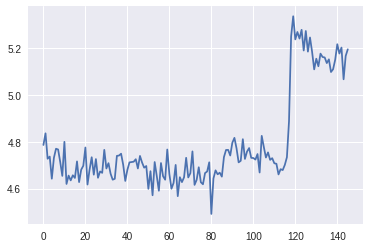

In [0]:
trainIters(encoder3, decoder3, encoder_optimizer, decoder_optimizer, n_iters, teacher_forcing_ratio, print_every=100, plot_every=100, learning_rate=learning_rate)

Calculate Bleu Score

In [0]:
from typing import List
from collections import Counter, namedtuple
from itertools import zip_longest

def tokenize_13a(line):
    """
    Tokenizes an input line using a relatively minimal tokenization that is however equivalent to mteval-v13a, used by WMT.
    :param line: a segment to tokenize
    :return: the tokenized line
    """

    norm = line

    # language-independent part:
    norm = norm.replace('<skipped>', '')
    norm = norm.replace('-\n', '')
    norm = norm.replace('\n', ' ')
    norm = norm.replace('&quot;', '"')
    norm = norm.replace('&amp;', '&')
    norm = norm.replace('&lt;', '<')
    norm = norm.replace('&gt;', '>')
    
    
        # language-dependent part (assuming Western languages):
    norm = " {} ".format(norm)
    norm = re.sub(r'([\{-\~\[-\` -\&\(-\+\:-\@\/])', ' \\1 ', norm)
    norm = re.sub(r'([^0-9])([\.,])', '\\1 \\2 ', norm)  # tokenize period and comma unless preceded by a digit
    norm = re.sub(r'([\.,])([^0-9])', ' \\1 \\2', norm)  # tokenize period and comma unless followed by a digit
    norm = re.sub(r'([0-9])(-)', '\\1 \\2 ', norm)  # tokenize dash when preceded by a digit
    norm = re.sub(r'\s+', ' ', norm)  # one space only between words
    norm = re.sub(r'^\s+', '', norm)  # no leading space
    norm = re.sub(r'\s+$', '', norm)  # no trailing space

    return norm

def corpus_bleu(sys_stream, ref_streams, smooth='exp', smooth_floor=0.0, force=False, lowercase=False,
                 use_effective_order=False):
    """Produces BLEU scores along with its sufficient statistics from a source against one or more references.
    :param sys_stream: The system stream (a sequence of segments)
    :param ref_streams: A list of one or more reference streams (each a sequence of segments)
    :param smooth: The smoothing method to use
    :param smooth_floor: For 'floor' smoothing, the floor to use
    :param force: Ignore data that looks already tokenized
    :param lowercase: Lowercase the data
    :param tokenize: The tokenizer to use
    :return: a BLEU object containing everything you'd want
    """

    # Add some robustness to the input arguments
    if isinstance(sys_stream, str):
        sys_stream = [sys_stream]
    if isinstance(ref_streams, str):
        ref_streams = [[ref_streams]]

    sys_len = 0
    ref_len = 0

    correct = [0 for n in range(NGRAM_ORDER)]
    total = [0 for n in range(NGRAM_ORDER)]
    

    # look for already-tokenized sentences
    tokenized_count = 0
    
    fhs = [sys_stream] + ref_streams
    for lines in zip_longest(*fhs):
        if None in lines:
            raise EOFError("Source and reference streams have different lengths!")

        if lowercase:
            lines = [x.lower() for x in lines]
            
        tokenize= 'tokenize_13a'    

        if not (force or tokenize == 'none') and lines[0].rstrip().endswith(' .'):
            tokenized_count += 1

            if tokenized_count == 100:
                logging.warning('That\'s 100 lines that end in a tokenized period (\'.\')')
                logging.warning('It looks like you forgot to detokenize your test data, which may hurt your score.')
                logging.warning('If you insist your data is detokenized, or don\'t care, you can suppress this message with \'--force\'.')

        output, *refs = [tokenize_13a(x.rstrip()) for x in lines]
        

        ref_ngrams, closest_diff, closest_len = ref_stats(output, refs)
        
        sys_len += len(output.split())
        ref_len += closest_len

        sys_ngrams = extract_ngrams(output)
        for ngram in sys_ngrams.keys():
            n = len(ngram.split())
            correct[n-1] += min(sys_ngrams[ngram], ref_ngrams.get(ngram, 0))
            total[n-1] += sys_ngrams[ngram]
            

    return compute_bleu(correct, total, sys_len, ref_len, smooth, smooth_floor, use_effective_order)
  
  
# n-gram order. Don't change this.
NGRAM_ORDER = 4

def compute_bleu(correct: List[int], total: List[int], sys_len: int, ref_len: int, smooth = 'none', smooth_floor = 0.01,
                 use_effective_order = False):
    """Computes BLEU score from its sufficient statistics. Adds smoothing.
    :param correct: List of counts of correct ngrams, 1 <= n <= NGRAM_ORDER
    :param total: List of counts of total ngrams, 1 <= n <= NGRAM_ORDER
    :param sys_len: The cumulative system length
    :param ref_len: The cumulative reference length
    :param smooth: The smoothing method to use
    :param smooth_floor: The smoothing value added, if smooth method 'floor' is used
    :param use_effective_order: Use effective order.
    :return: A BLEU object with the score (100-based) and other statistics.
    """

    precisions = [0 for x in range(NGRAM_ORDER)]

    smooth_mteval = 1.
    effective_order = NGRAM_ORDER
    for n in range(NGRAM_ORDER):
        if total[n] == 0:
            break

        if use_effective_order:
            effective_order = n + 1

        if correct[n] == 0:
            if smooth == 'exp':
                smooth_mteval *= 2
                precisions[n] = 100. / (smooth_mteval * total[n])
            elif smooth == 'floor':
                precisions[n] = 100. * smooth_floor / total[n]
        else:
          precisions[n] = 100. * correct[n] / total[n]

    # If the system guesses no i-grams, 1 <= i <= NGRAM_ORDER, the BLEU score is 0 (technically undefined).
    # This is a problem for sentence-level BLEU or a corpus of short sentences, where systems will get no credit
    # if sentence lengths fall under the NGRAM_ORDER threshold. This fix scales NGRAM_ORDER to the observed
    # maximum order. It is only available through the API and off by default

    brevity_penalty = 1.0
    if sys_len < ref_len:
        brevity_penalty = math.exp(1 - ref_len / sys_len) if sys_len > 0 else 0.0
        

    bleu = brevity_penalty * math.exp(sum(map(my_log, precisions[:effective_order])) / effective_order)

    return bleu 
  
def ref_stats(output, refs):
    ngrams = Counter()
    closest_diff = None
    closest_len = None
    for ref in refs:
        tokens = ref.split()
        reflen = len(tokens)
        diff = abs(len(output.split()) - reflen)
        if closest_diff is None or diff < closest_diff:
            closest_diff = diff
            closest_len = reflen
        elif diff == closest_diff:
            if reflen < closest_len:
                closest_len = reflen

        ngrams_ref = extract_ngrams(ref)
        for ngram in ngrams_ref.keys():
            ngrams[ngram] = max(ngrams[ngram], ngrams_ref[ngram])

    return ngrams, closest_diff, closest_len
  

def extract_ngrams(line, min_order=1, max_order=NGRAM_ORDER) -> Counter:
    """Extracts all the ngrams (1 <= n <= NGRAM_ORDER) from a sequence of tokens.
    :param line: a segment containing a sequence of words
    :param max_order: collect n-grams from 1<=n<=max
    :return: a dictionary containing ngrams and counts
    """

    ngrams = Counter()
    tokens = line.split()
    for n in range(min_order, max_order + 1):
        for i in range(0, len(tokens) - n + 1):
            ngram = ' '.join(tokens[i: i + n])
            ngrams[ngram] += 1

    return ngrams  
  

  
def my_log(num):
    """
    Floors the log function
    :param num: the number
    :return: log(num) floored to a very low number
    """

    if num == 0.0:
        return -9999999999
    return math.log(num)
  


In [0]:
def evaluate_batch(loader, encoder, decoder):
    
    decoded_sentences = []
    actual_sentences = []
    
    for i, (source, lengths1, target, lengths2) in enumerate(loader):
        #iterate over batch
        
        for n in range(len(source)):
            # Go sentence by sentence
            
            decoded, actual = evaluate(encoder, decoder, source[n].unsqueeze(0), lengths1[n], target[n])
            decoded_sentences.append(decoded)
            actual_sentences.append(actual)
            
    return decoded_sentences, actual_sentences


def evaluate_bleu(translation_list, reference_list):
    
    return corpus_bleu(translation_list, [reference_list])

In [0]:
def evaluate(encoder, decoder, sentence, input_lengths, translated, search='greedy', max_length=MAX_LENGTH):
    """
    Function that generate translation.
    First, feed the source sentence into the encoder and obtain the hidden states from encoder.
    Secondly, feed the hidden states into the decoder and unfold the outputs from the decoder.
    Lastly, for each outputs from the decoder, collect the corresponding words in the target language's vocabulary.
    And collect the attention for each output words.
    @param encoder: the encoder network
    @param decoder: the decoder network
    @param sentence: string, a sentence in source language to be translated
    @param max_length: the max # of words that the decoder can return
    @output decoded_words: a list of words in target language
    @output decoder_attentions: a list of vector, each of which sums up to 1.0
    """    
    # process input sentence
    with torch.no_grad():
        input_tensor = sentence.transpose(0,1).to(device)
        #input_length = sentence.size()[0]
        encoder_output, encoder_hidden = encoder(input_tensor, [input_lengths.item()], None)

        decoder_input = Variable(torch.LongTensor([SOS_token])).to(device) # SOS
        decoder_hidden = encoder_hidden[:decoder.n_layers] # Use last (forward) hidden state from encoder 
        # output of this function
        decoded_words = ''

        for di in range(max_length):
            # for each time step, the decoder network takes two inputs: previous outputs and the previous hidden states
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            
            
            # GREEDY
            topv, topi = decoder_output.data.topk(1) 

            if topi.item() == EOS_token:
                #decoded_words.append('<EOS>')
                break
            else:
                if topi.item() not in [SOS_token, EOS_token, UNK_IDX, PAD_IDX]:
                    decoded_words = decoded_words + ' ' + val_output_lang.index2word[topi.item()]
            
            decoder_input = topi[0].detach()
        
        translation = ''
        for i in translated: #expected translation
            if i.item() not in [SOS_token, EOS_token, UNK_IDX, PAD_IDX]:
                translation = translation + ' ' + val_output_lang.index2word[i.item()]

        return decoded_words, translation

In [0]:
# Configure models
hidden_size = 500
layers = 2
teacher_forcing_ratio = 0.5
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iters = 10000

encoder3 = EncoderRNN(weights_matrix_zh, train_input_lang.n_words, hidden_size, n_layers = layers).to(device)
decoder3 = DecoderRNN(weights_matrix_eng, hidden_size, train_output_lang.n_words, n_layers = layers).to(device)

encoder_optimizer = optim.SGD(encoder3.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(decoder3.parameters(), lr=learning_rate * decoder_learning_ratio)

encoder3.load_state_dict(torch.load(folder_path + "encoder3.pt"))
decoder3.load_state_dict(torch.load(folder_path +"decoder3.pt"))


EOFError: ignored

In [0]:
decoded, actual = evaluate_batch(val_loader, encoder3, decoder3)

for i in zip(decoded, actual):
    if i == 10:
        break
    print('\n')
    print('Expected:', i[1])
    print('Actual:' ,i[0])



Expected:  She retired two years ago only to turn our house into a school for girls and women in our neighborhood .
Actual:  And the and and and and and and and and and and and and and and and the and and and the and and the . .


Expected:  There was a big smile on his face which was unusual then because the news mostly depressed him .
Actual:  He s the most most most most most most most most most most most most most most most most most most most most most most most . .


Expected:  And my father that s him he was the first ever in his family to receive an education .
Actual:  He was he was first first first first was one was who first first .


Expected:  We all knew we were risking our lives the teacher the students and our parents .
Actual:  And we know know know know the know and and and and and and and and and . . . . . . .


Expected:  When I was I remember waking up one morning to the sound of joy in my house .
Actual:  And the remember the remember the remember the remember 

In [0]:
evaluate_bleu(decoded, actual)

0.48256344982634763

Try Teacher_forcing_ratio = 1 on sample data with max_word_length = 15. Dec.3th

In [0]:
MAX_LENGTH_S = 15
#train model on sample data first

def filterPair_sample(p):
    return len(p[0].split(' ')) < MAX_LENGTH_S and \
        len(p[1].split(' ')) < MAX_LENGTH_S



def filterPairs_sample(pairs):
    return [pair for pair in pairs if filterPair_sample(pair)]
  
  
def readLanguages_sample(input_lang,target_lang):
    print("\nReading lines...")

    # Read the file and split into lines
    input_lines = open(folder_path + input_lang, encoding='utf-8').\
        read().strip().split('\n')
    target_lines = open(folder_path + target_lang, encoding='utf-8').\
        read().strip().split('\n')

    # Split every line and normalize
    #for chinese input, strip the space at the begining and end of the sentence
    #for english output, use normalizeString function
    sample_input = input_lines[:10000]
    sample_target = target_lines[:10000]
    
    input_lines_norm = [l.strip() for l in sample_input]
    target_lines_norm = [normalizeString(l) for l in sample_target]
    
    #build pairs
    #drop pair if both zh and en are empty strings
    pairs = [[item[0],item[1]] for item in zip(input_lines_norm,target_lines_norm) if len(item[0])+len(item[1]) != 0]
    
    input_lines = Language("zh",words2id_zh,idx2words_zh)
    target_lines = Language("en",words2id_eng,idx2words_eng)

    return input_lines, target_lines, pairs

  
def prepareData_sample(input_lang, target_lang):
    input_lang, output_lang, pairs = readLanguages_sample(input_lang, target_lang)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs_sample(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")

    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    
    return input_lang, output_lang, pairs


In [0]:
train_input_lang_sample, train_output_lang_sample, train_pairs_sample = prepareData_sample(train_zh, train_en)
print("print a random pair of training pairs:")
print(random.choice(train_pairs_sample))



Reading lines...
Read 10000 sentence pairs
Trimmed to 3718 sentence pairs
Counting words...
Counted words:
zh 50004
en 50004
print a random pair of training pairs:
['通常 常人 人们 称之为 之为   经济 经济负担 负担 能力', 'And it s called affordability .']


In [0]:
val_input_lang_sample, val_output_lang_sample, val_pairs_sample = prepareData_sample(val_zh, val_en)
print("print a random pair of validation pairs:")
print(random.choice(val_pairs_sample))


Reading lines...
Read 1261 sentence pairs
Trimmed to 411 sentence pairs
Counting words...
Counted words:
zh 50004
en 50004
print a random pair of validation pairs:
['我 要质 质疑 它   你们 知道 为什么 什么 吗', 'I want to challenge that . Do you know why ?']


In [0]:
#Build sample train and valid dataloaders 

train_dataset_sample = VocabDataset(train_pairs_sample,train_input_lang_sample, train_output_lang_sample)
train_loader_sample = torch.utils.data.DataLoader(dataset=train_dataset_sample,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True,
                                           drop_last = True)



In [0]:
val_dataset_sample = VocabDataset(val_pairs_sample,val_input_lang_sample,val_output_lang_sample)
val_loader_sample = torch.utils.data.DataLoader(dataset=val_dataset_sample,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=False,
                                         drop_last = True)

In [0]:
def trainIters_sample(encoder, decoder, encoder_optimizer, decoder_optimizer, n_iters, teacher_forcing_ratio, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    criterion = nn.NLLLoss()
    iters = 0
    
    while iters <= n_iters:
      
      
      
      for i, (input_var,input_data_len,output_var,output_data_len) in enumerate(train_loader_sample):
        iters += 1
        input_batch = input_var.transpose(0,1).to(device)
        output_batch = output_var.transpose(0,1).to(device)
        
        loss = train(input_batch,input_data_len,output_batch,output_data_len, encoder,
                       decoder, encoder_optimizer, decoder_optimizer, criterion,teacher_forcing_ratio)
       
        
        # Keep track of loss
        print_loss_total += loss
        plot_loss_total += loss


        if iters % print_every == 0:

          print_loss_avg = print_loss_total / print_every
          print_loss_total = 0
          print('%s (%d %d%%) %.4f' % (timeSince(start, iters / n_iters),
                                           iters, iters / n_iters * 100, print_loss_avg))

        if iters % plot_every == 0:
          plot_loss_avg = plot_loss_total / plot_every
          plot_losses.append(plot_loss_avg)
          plot_loss_total = 0

    showPlot(plot_losses)

In [0]:
# Configure models
hidden_size = 500
layers = 3
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iters = 10000


# Initialize models
encoder = EncoderRNN(weights_matrix_zh, train_input_lang.n_words, hidden_size, n_layers = layers).to(device)
decoder = DecoderRNN(weights_matrix_eng, hidden_size, train_output_lang.n_words, n_layers = layers).to(device)

# Initialize optimizers and criterion
encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)


1m 20s (- 132m 13s) (100 1%) 10.7944
2m 40s (- 130m 49s) (200 2%) 10.5697
4m 0s (- 129m 23s) (300 3%) 9.6967
5m 20s (- 128m 5s) (400 4%) 9.0233
6m 40s (- 126m 47s) (500 5%) 8.2529
7m 59s (- 125m 18s) (600 6%) 7.7256
9m 19s (- 123m 52s) (700 7%) 7.6036
10m 38s (- 122m 27s) (800 8%) 7.3320
11m 58s (- 121m 6s) (900 9%) 7.0592
13m 18s (- 119m 43s) (1000 10%) 6.6840
14m 37s (- 118m 21s) (1100 11%) 6.4914
15m 57s (- 117m 0s) (1200 12%) 6.3011
17m 16s (- 115m 38s) (1300 13%) 6.1970
18m 36s (- 114m 18s) (1400 14%) 6.0719
19m 55s (- 112m 56s) (1500 15%) 5.9787
21m 15s (- 111m 35s) (1600 16%) 5.8724
22m 35s (- 110m 16s) (1700 17%) 5.7504
23m 55s (- 108m 58s) (1800 18%) 5.6932
25m 15s (- 107m 38s) (1900 19%) 5.6002
26m 35s (- 106m 20s) (2000 20%) 5.5490
27m 54s (- 105m 0s) (2100 21%) 5.4838
29m 14s (- 103m 42s) (2200 22%) 5.4198
30m 34s (- 102m 22s) (2300 23%) 5.3890
31m 54s (- 101m 1s) (2400 24%) 5.3473
33m 14s (- 99m 42s) (2500 25%) 5.2770
34m 34s (- 98m 23s) (2600 26%) 5.2620
35m 54s (- 97m 4s

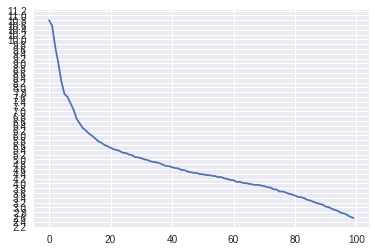

In [0]:
trainIters_sample(encoder, decoder, encoder_optimizer, decoder_optimizer, n_iters, teacher_forcing_ratio, print_every=100, plot_every=100, learning_rate=learning_rate)

In [0]:
torch.save(encoder.state_dict(), folder_path + 'encoder_1204.pt')
torch.save(decoder.state_dict(), folder_path + 'decoder_1204.pt')

Continue training the model. Dec 5th


In [0]:
# Configure models
hidden_size = 500
layers = 3
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iters = 10000

# Initialize models
encoder = EncoderRNN(weights_matrix_zh, train_input_lang.n_words, hidden_size, n_layers = layers).to(device)
decoder = DecoderRNN(weights_matrix_eng, hidden_size, train_output_lang.n_words, n_layers = layers).to(device)

encoder.load_state_dict(torch.load(folder_path + "encoder_1204.pt"))
decoder.load_state_dict(torch.load(folder_path +"decoder_1204.pt"))

# Initialize optimizers and criterion
encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)

In [0]:
decoded, actual = evaluate_batch(val_loader_sample, encoder, decoder)

for i in zip(decoded, actual):
    if i == 10:
        break
    print('\n')
    print('Expected:', i[1])
    print('Actual:' ,i[0])



Expected:  We were scared but still school was where we wanted to be .
Actual:  They we also learn down to school every distance also well .


Expected:  Instead I stand here a proud graduate of Middlebury College .
Actual:  And that s the mountain which I was working to the head .


Expected:  But today more than three million girls are in school in Afghanistan .
Actual:  But s why s the life is only a poem pounds now to himself .


Expected:  I find that Americans see the fragility in changes .
Actual:  I m how how I focus focus the population condition .


Expected:  Just in the nick of time to save the Zambian people from starvation .
Actual:  In two years hand of swimming called and stop it s called .


Expected:  And of course everything in Africa grew beautifully .
Actual:  That of these dimension will .


Expected:  The Taliban are gone ! my father shouted .
Actual:  I built the end making a on him .


Expected:  My grandfather was an extraordinary man for his time .
Actual: 

In [0]:
# torch.save(encoder.state_dict(), folder_path + 'encoder_1204.pt')
# torch.save(decoder.state_dict(), folder_path + 'decoder_1204.pt')

Train model with teacher_forcing_ratio = 1. Dec 5th

In [0]:
# Configure models
hidden_size = 500
layers = 3
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iters = 10000


# Initialize models
encoder = EncoderRNN(weights_matrix_zh, train_input_lang.n_words, hidden_size, n_layers = layers).to(device)
decoder = DecoderRNN(weights_matrix_eng, hidden_size, train_output_lang.n_words, n_layers = layers).to(device)

# Initialize optimizers and criterion
encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)


1m 41s (- 166m 39s) (100 1%) 11.1294
3m 21s (- 164m 41s) (200 2%) 10.9822
5m 2s (- 163m 0s) (300 3%) 10.3836
6m 43s (- 161m 21s) (400 4%) 9.4353
8m 24s (- 159m 38s) (500 5%) 8.8199
10m 4s (- 157m 56s) (600 6%) 8.3976
11m 45s (- 156m 18s) (700 7%) 8.3550
13m 26s (- 154m 36s) (800 8%) 7.9802
15m 7s (- 152m 55s) (900 9%) 7.8568
16m 48s (- 151m 14s) (1000 10%) 7.6424
18m 28s (- 149m 32s) (1100 11%) 7.4094
20m 9s (- 147m 51s) (1200 12%) 7.2771
21m 50s (- 146m 10s) (1300 13%) 7.1140
23m 31s (- 144m 28s) (1400 14%) 6.9857
25m 11s (- 142m 46s) (1500 15%) 6.9131
26m 52s (- 141m 5s) (1600 16%) 6.7393
28m 33s (- 139m 24s) (1700 17%) 6.6673
30m 13s (- 137m 43s) (1800 18%) 6.5301
31m 54s (- 136m 2s) (1900 19%) 6.4782
33m 35s (- 134m 21s) (2000 20%) 6.3532
35m 16s (- 132m 40s) (2100 21%) 6.3331
36m 56s (- 131m 0s) (2200 22%) 6.2140
38m 37s (- 129m 19s) (2300 23%) 6.1739
40m 18s (- 127m 38s) (2400 24%) 6.1557
41m 59s (- 125m 58s) (2500 25%) 6.1152
43m 40s (- 124m 16s) (2600 26%) 6.0447
45m 20s (- 122

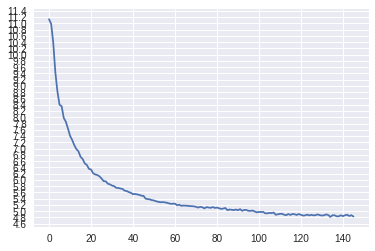

In [0]:
trainIters(encoder, decoder, encoder_optimizer, decoder_optimizer, n_iters, teacher_forcing_ratio, print_every=100, plot_every=100, learning_rate=learning_rate)

In [0]:
torch.save(encoder.state_dict(), folder_path + 'encoder_1207.pt')
torch.save(decoder.state_dict(), folder_path + 'decoder_1207.pt')

In [0]:
# Configure models
hidden_size = 500
layers = 3
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iters = 10000


# Initialize models
encoder = EncoderRNN(weights_matrix_zh, train_input_lang.n_words, hidden_size, n_layers = layers).to(device)
decoder = DecoderRNN(weights_matrix_eng, hidden_size, train_output_lang.n_words, n_layers = layers).to(device)

# Initialize optimizers and criterion
encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)

encoder.load_state_dict(torch.load(folder_path + "encoder_1207.pt"))
decoder.load_state_dict(torch.load(folder_path +"decoder_1207.pt"))


In [0]:
torch.save(encoder.state_dict(), folder_path + 'encoder_1208.pt')
torch.save(decoder.state_dict(), folder_path + 'decoder_1208.pt')

In [0]:
decoded, actual = evaluate_batch(val_loader, encoder, decoder)

for i in zip(decoded, actual):
    if i == 10:
        break
    print('\n')
    print('Expected:', i[1])
    print('Actual:' ,i[0])



Expected:  She retired two years ago only to turn our house into a school for girls and women in our neighborhood .
Actual:  She was a the old and the and the and the of the United States .


Expected:  There was a big smile on his face which was unusual then because the news mostly depressed him .
Actual:  If he was a little time of the same time that he has to be a good time .


Expected:  And my father that s him he was the first ever in his family to receive an education .
Actual:  My father is a of a .


Expected:  We all knew we were risking our lives the teacher the students and our parents .
Actual:  We have to be a very good way of the same time and we re going to be very much to be a very good time .


Expected:  When I was I remember waking up one morning to the sound of joy in my house .
Actual:  I was a was by the of the of the time I was a .


Expected:  I didn t know what it meant but I could see that my father was very very happy .
Actual:  I m very really very very g

In [0]:
evaluate_bleu(decoded,actual)

1.2779485402890656

In [0]:
corpus_bleu('She s not North Korean .','She was not the same one .')

9.042266054940777

In [0]:
corpus_bleu('She s not North Korean .','She was not not not not not not the same one .')

3.9297526283216277

In [0]:
corpus_bleu('Thank you .','Thank you .')

0.0

1m 33s (- 154m 42s) (100 1%) 4.7553
3m 7s (- 153m 9s) (200 2%) 4.7351
4m 41s (- 151m 30s) (300 3%) 4.6612
6m 14s (- 149m 57s) (400 4%) 4.6894
7m 48s (- 148m 25s) (500 5%) 4.6459
9m 22s (- 146m 52s) (600 6%) 4.6603
10m 56s (- 145m 16s) (700 7%) 4.6967
12m 29s (- 143m 43s) (800 8%) 4.6649
14m 3s (- 142m 11s) (900 9%) 4.6895
15m 37s (- 140m 36s) (1000 10%) 4.6737
17m 10s (- 139m 1s) (1100 11%) 4.6430
18m 44s (- 137m 27s) (1200 12%) 4.6707
20m 18s (- 135m 53s) (1300 13%) 4.6567
21m 52s (- 134m 19s) (1400 14%) 4.5987
23m 25s (- 132m 46s) (1500 15%) 4.6500
24m 59s (- 131m 12s) (1600 16%) 4.6255
26m 32s (- 129m 37s) (1700 17%) 4.6222
28m 6s (- 128m 3s) (1800 18%) 4.5924
29m 40s (- 126m 29s) (1900 19%) 4.6314
31m 13s (- 124m 54s) (2000 20%) 4.6543
32m 47s (- 123m 20s) (2100 21%) 4.6201
34m 21s (- 121m 47s) (2200 22%) 4.6609
35m 54s (- 120m 13s) (2300 23%) 4.6229
37m 28s (- 118m 40s) (2400 24%) 4.6670
39m 2s (- 117m 7s) (2500 25%) 4.6478
40m 36s (- 115m 33s) (2600 26%) 4.6544
42m 9s (- 114m 0s)

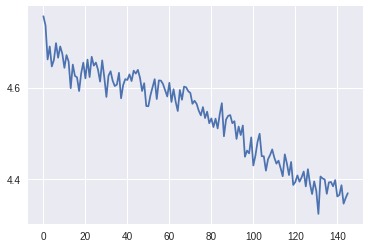

In [0]:
trainIters(encoder, decoder, encoder_optimizer, decoder_optimizer, n_iters, teacher_forcing_ratio, print_every=100, plot_every=100, learning_rate=learning_rate)

In [0]:
# Configure models
hidden_size = 500
layers = 3
teacher_forcing_ratio = 1.0
learning_rate = 0.00005
decoder_learning_ratio = 5.0
n_iters = 10000


# Initialize models
encoder = EncoderRNN(weights_matrix_zh, train_input_lang.n_words, hidden_size, n_layers = layers).to(device)
decoder = DecoderRNN(weights_matrix_eng, hidden_size, train_output_lang.n_words, n_layers = layers).to(device)

# Initialize optimizers and criterion
encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)

encoder.load_state_dict(torch.load(folder_path + "encoder_1208.pt"))
decoder.load_state_dict(torch.load(folder_path +"decoder_1208.pt"))


1m 33s (- 154m 22s) (100 1%) 4.2874
3m 7s (- 153m 3s) (200 2%) 4.2487
4m 41s (- 151m 26s) (300 3%) 4.2149
6m 14s (- 149m 45s) (400 4%) 4.2255
7m 47s (- 148m 9s) (500 5%) 4.2003
9m 21s (- 146m 35s) (600 6%) 4.1993
10m 54s (- 144m 59s) (700 7%) 4.1834
12m 28s (- 143m 24s) (800 8%) 4.1963
14m 1s (- 141m 51s) (900 9%) 4.1464
15m 35s (- 140m 17s) (1000 10%) 4.1820
17m 8s (- 138m 42s) (1100 11%) 4.1819
18m 42s (- 137m 11s) (1200 12%) 4.1626
20m 16s (- 135m 42s) (1300 13%) 4.1621
21m 50s (- 134m 11s) (1400 14%) 4.1452
23m 24s (- 132m 40s) (1500 15%) 4.1695
24m 59s (- 131m 9s) (1600 16%) 4.1382
26m 33s (- 129m 37s) (1700 17%) 4.1314
28m 7s (- 128m 5s) (1800 18%) 4.1488
29m 41s (- 126m 34s) (1900 19%) 4.1433
31m 15s (- 125m 2s) (2000 20%) 4.1390
32m 49s (- 123m 30s) (2100 21%) 4.1495
34m 24s (- 121m 58s) (2200 22%) 4.1551
35m 58s (- 120m 26s) (2300 23%) 4.1584
37m 32s (- 118m 53s) (2400 24%) 4.1149
39m 7s (- 117m 21s) (2500 25%) 4.1226
40m 41s (- 115m 48s) (2600 26%) 4.1259
42m 15s (- 114m 15s)

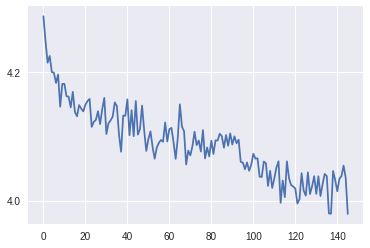

In [0]:
trainIters(encoder, decoder, encoder_optimizer, decoder_optimizer, n_iters, teacher_forcing_ratio, print_every=100, plot_every=100, learning_rate=learning_rate)

In [0]:
torch.save(encoder.state_dict(), folder_path + 'encoder_1208.pt')
torch.save(decoder.state_dict(), folder_path + 'decoder_1208.pt')

In [0]:
decoded, actual = evaluate_batch(val_loader, encoder, decoder)

for i in zip(decoded, actual):
    if i == 10:
        break
    print('\n')
    print('Expected:', i[1])
    print('Actual:' ,i[0])



Expected:  She retired two years ago only to turn our house into a school for girls and women in our neighborhood .
Actual:  She s a year old years old and women were a family who were going to get home in the hospital .


Expected:  There was a big smile on his face which was unusual then because the news mostly depressed him .
Actual:  He s most most likely but most of the most times of the most times of the most times of it is .


Expected:  And my father that s him he was the first ever in his family to receive an education .
Actual:  My father he was a person who was born in his family .


Expected:  We all knew we were risking our lives the teacher the students and our parents .
Actual:  We know that that s all that that s all of us is that kids are going to be very happy .


Expected:  When I was I remember waking up one morning to the sound of joy in my house .
Actual:  I was in night day day day day day day day day day day day day day .


Expected:  I didn t know what it mea

In [0]:
evaluate_bleu(decoded,actual)

3.019498661522269

In [0]:
# Configure models
hidden_size = 500
layers = 3
teacher_forcing_ratio = 1.0
learning_rate = 0.00001
decoder_learning_ratio = 2.0
n_iters = 10000


# Initialize models
encoder = EncoderRNN(weights_matrix_zh, train_input_lang.n_words, hidden_size, n_layers = layers).to(device)
decoder = DecoderRNN(weights_matrix_eng, hidden_size, train_output_lang.n_words, n_layers = layers).to(device)

# Initialize optimizers and criterion
encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)

encoder.load_state_dict(torch.load(folder_path + "encoder_1208.pt"))
decoder.load_state_dict(torch.load(folder_path +"decoder_1208.pt"))


1m 32s (- 152m 37s) (100 1%) 3.9695
3m 4s (- 150m 52s) (200 2%) 3.9544
4m 36s (- 149m 12s) (300 3%) 3.9145
6m 9s (- 147m 37s) (400 4%) 3.9425
7m 41s (- 146m 4s) (500 5%) 3.9030
9m 13s (- 144m 33s) (600 6%) 3.9120
10m 46s (- 143m 2s) (700 7%) 3.9440
12m 18s (- 141m 28s) (800 8%) 3.9277
13m 50s (- 139m 56s) (900 9%) 3.9343
15m 22s (- 138m 23s) (1000 10%) 3.9058
16m 54s (- 136m 49s) (1100 11%) 3.8895
18m 26s (- 135m 17s) (1200 12%) 3.9017
19m 59s (- 133m 44s) (1300 13%) 3.8856
21m 31s (- 132m 12s) (1400 14%) 3.8853
23m 3s (- 130m 38s) (1500 15%) 3.8579
24m 35s (- 129m 6s) (1600 16%) 3.8903
26m 7s (- 127m 35s) (1700 17%) 3.8836
27m 39s (- 126m 1s) (1800 18%) 3.9041
29m 12s (- 124m 30s) (1900 19%) 3.8936
30m 44s (- 122m 58s) (2000 20%) 3.8830
32m 16s (- 121m 26s) (2100 21%) 3.8902
33m 49s (- 119m 54s) (2200 22%) 3.8622
35m 21s (- 118m 23s) (2300 23%) 3.8919
36m 54s (- 116m 51s) (2400 24%) 3.8509
38m 26s (- 115m 19s) (2500 25%) 3.8649
39m 58s (- 113m 46s) (2600 26%) 3.8354
41m 30s (- 112m 13

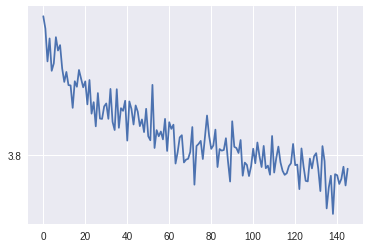

In [0]:
trainIters(encoder, decoder, encoder_optimizer, decoder_optimizer, n_iters, teacher_forcing_ratio, print_every=100, plot_every=100, learning_rate=learning_rate)

In [0]:
torch.save(encoder.state_dict(), folder_path + 'encoder_1209.pt')
torch.save(decoder.state_dict(), folder_path + 'decoder_1209.pt')

In [0]:
decoded, actual = evaluate_batch(val_loader, encoder, decoder)

for i in zip(decoded, actual):
    if i == 10:
        break
    print('\n')
    print('Expected:', i[1])
    print('Actual:' ,i[0])



Expected:  She retired two years ago only to turn our house into a school for girls and women in our neighborhood .
Actual:  She went years ago to be a family of the village and the girls of the family of the family of the family .


Expected:  There was a big smile on his face which was unusual then because the news mostly depressed him .
Actual:  He s the most most most most people but the most most most most of the things are the most most of the most people .


Expected:  And my father that s him he was the first ever in his family to receive an education .
Actual:  My father was a man who was born in the first job .


Expected:  We all knew we were risking our lives the teacher the students and our parents .
Actual:  We know that the kids are all the children and the kids are learning .


Expected:  When I was I remember waking up one morning to the sound of joy in my house .
Actual:  When I was sitting from the morning I was sitting from the morning of the morning .


Expected:

In [0]:
evaluate_bleu(decoded,actual)

3.504301351357001

In [0]:
# Configure models
hidden_size = 500
layers = 3
teacher_forcing_ratio = 1.0
learning_rate = 0.000005
decoder_learning_ratio = 2.0
n_iters = 10000


# Initialize models
encoder = EncoderRNN(weights_matrix_zh, train_input_lang.n_words, hidden_size, n_layers = layers).to(device)
decoder = DecoderRNN(weights_matrix_eng, hidden_size, train_output_lang.n_words, n_layers = layers).to(device)

# Initialize optimizers and criterion
encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)

encoder.load_state_dict(torch.load(folder_path + "encoder_1209.pt"))
decoder.load_state_dict(torch.load(folder_path +"decoder_1209.pt"))


1m 32s (- 152m 33s) (100 1%) 3.7585
3m 4s (- 150m 47s) (200 2%) 3.7856
4m 36s (- 149m 7s) (300 3%) 3.7460
6m 8s (- 147m 31s) (400 4%) 3.7659
7m 40s (- 145m 58s) (500 5%) 3.7468
9m 12s (- 144m 22s) (600 6%) 3.7375
10m 44s (- 142m 48s) (700 7%) 3.7416
12m 17s (- 141m 16s) (800 8%) 3.7802
13m 49s (- 139m 43s) (900 9%) 3.7265
15m 21s (- 138m 11s) (1000 10%) 3.7439
16m 53s (- 136m 39s) (1100 11%) 3.7411
18m 25s (- 135m 7s) (1200 12%) 3.7132
19m 57s (- 133m 34s) (1300 13%) 3.7509
21m 29s (- 132m 2s) (1400 14%) 3.7138
23m 1s (- 130m 30s) (1500 15%) 3.6962
24m 33s (- 128m 57s) (1600 16%) 3.7228
26m 6s (- 127m 26s) (1700 17%) 3.7603
27m 38s (- 125m 54s) (1800 18%) 3.7341
29m 10s (- 124m 21s) (1900 19%) 3.6982
30m 42s (- 122m 48s) (2000 20%) 3.7131
32m 14s (- 121m 16s) (2100 21%) 3.7246
33m 46s (- 119m 44s) (2200 22%) 3.7199
35m 18s (- 118m 12s) (2300 23%) 3.7162
36m 50s (- 116m 39s) (2400 24%) 3.7123
38m 22s (- 115m 7s) (2500 25%) 3.7023
39m 54s (- 113m 35s) (2600 26%) 3.7434
41m 26s (- 112m 3s

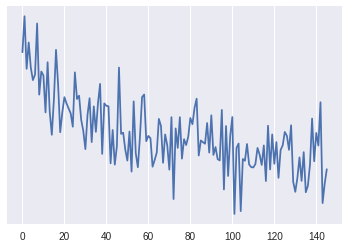

In [0]:
trainIters(encoder, decoder, encoder_optimizer, decoder_optimizer, n_iters, teacher_forcing_ratio, print_every=100, plot_every=100, learning_rate=learning_rate)

In [0]:
decoded, actual = evaluate_batch(val_loader, encoder, decoder)

for i in zip(decoded, actual):
    if i == 10:
        break
    print('\n')
    print('Expected:', i[1])
    print('Actual:' ,i[0])



Expected:  She retired two years ago only to turn our house into a school for girls and women in our neighborhood .
Actual:  She was a year old years old and girls and girls and girls and girls .


Expected:  There was a big smile on his face which was unusual then because the news mostly depressed him .
Actual:  He was most most most most likely to see but he s been most good but he s still just seen the most good .


Expected:  And my father that s him he was the first ever in his family to receive an education .
Actual:  And my father was a man who was a great job in the first family .


Expected:  We all knew we were risking our lives the teacher the students and our parents .
Actual:  We know that the kids are all the kids and the kids are not going to know .


Expected:  When I was I remember waking up one morning to the sound of joy in my house .
Actual:  I was in the morning of the morning I was sitting in a day .


Expected:  I didn t know what it meant but I could see that 

In [0]:
evaluate_bleu(decoded,actual)

4.008106867338089

In [0]:
# Configure models
hidden_size = 500
layers = 3
teacher_forcing_ratio = 1.0
learning_rate = 0.01
decoder_learning_ratio = 2.0
n_iters = 10000


# Initialize models
encoder = EncoderRNN(weights_matrix_zh, train_input_lang.n_words, hidden_size, n_layers = layers).to(device)
decoder = DecoderRNN(weights_matrix_eng, hidden_size, train_output_lang.n_words, n_layers = layers).to(device)

# Initialize optimizers and criterion
encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)

encoder.load_state_dict(torch.load(folder_path + "encoder_1209.pt"))
decoder.load_state_dict(torch.load(folder_path +"decoder_1209.pt"))


1m 29s (- 147m 54s) (100 1%) 3.7645
2m 58s (- 145m 57s) (200 2%) 3.7154
4m 28s (- 144m 27s) (300 3%) 3.7486
5m 57s (- 143m 0s) (400 4%) 3.7387
7m 26s (- 141m 26s) (500 5%) 3.6926
8m 55s (- 139m 55s) (600 6%) 3.7140
10m 25s (- 138m 26s) (700 7%) 3.7093
11m 54s (- 136m 55s) (800 8%) 3.6992
13m 23s (- 135m 25s) (900 9%) 3.6654
14m 52s (- 133m 56s) (1000 10%) 3.7090
16m 22s (- 132m 27s) (1100 11%) 3.6906
17m 51s (- 130m 58s) (1200 12%) 3.7094
19m 20s (- 129m 28s) (1300 13%) 3.6941
20m 50s (- 127m 58s) (1400 14%) 3.6912
22m 19s (- 126m 28s) (1500 15%) 3.6972
23m 48s (- 124m 58s) (1600 16%) 3.6942
25m 17s (- 123m 30s) (1700 17%) 3.6954
26m 47s (- 122m 1s) (1800 18%) 3.6948
28m 16s (- 120m 32s) (1900 19%) 3.7042
29m 45s (- 119m 3s) (2000 20%) 3.7091
31m 15s (- 117m 34s) (2100 21%) 3.7034
32m 44s (- 116m 5s) (2200 22%) 3.6674
34m 13s (- 114m 35s) (2300 23%) 3.6780
35m 43s (- 113m 6s) (2400 24%) 3.7271
37m 12s (- 111m 37s) (2500 25%) 3.7186
38m 41s (- 110m 7s) (2600 26%) 3.6805
40m 10s (- 108m 

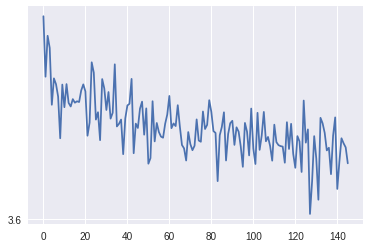

In [0]:
trainIters(encoder, decoder, encoder_optimizer, decoder_optimizer, n_iters, teacher_forcing_ratio, print_every=100, plot_every=100, learning_rate=learning_rate)

In [0]:
torch.save(encoder.state_dict(), folder_path + 'encoder_1210.pt')
torch.save(decoder.state_dict(), folder_path + 'decoder_1210.pt')

In [0]:
decoded, actual = evaluate_batch(val_loader, encoder, decoder)

for i in zip(decoded, actual):
    if i == 10:
        break
    print('\n')
    print('Expected:', i[1])
    print('Actual:' ,i[0])



Expected:  She retired two years ago only to turn our house into a school for girls and women in our neighborhood .
Actual:  She went into a family and she went to school and she went to school and she went to school .


Expected:  There was a big smile on his face which was unusual then because the news mostly depressed him .
Actual:  He s the most most most most most of the people but the most few of the things are the most most of the most most of the most people


Expected:  And my father that s him he was the first ever in his family to receive an education .
Actual:  My father was a man who was born in his father .


Expected:  We all knew we were risking our lives the teacher the students and our parents .
Actual:  We know that we know all of the children and children are all of our children .


Expected:  When I was I remember waking up one morning to the sound of joy in my house .
Actual:  I was in night when I was in the morning of my daughter and I was a kid .


Expected: 

In [0]:
evaluate_bleu(decoded,actual)

4.176573728324879

In [0]:
# Configure models
hidden_size = 500
layers = 1
teacher_forcing_ratio = 1.0
learning_rate = 0.001
decoder_learning_ratio = 2.0
n_iters = 10000


# Initialize models
encoder = EncoderRNN(weights_matrix_zh, train_input_lang.n_words, hidden_size, n_layers = layers).to(device)
decoder = DecoderRNN(weights_matrix_eng, hidden_size, train_output_lang.n_words, n_layers = layers).to(device)

# Initialize optimizers and criterion
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)



1m 12s (- 119m 36s) (100 1%) 6.8829
2m 25s (- 118m 25s) (200 2%) 6.0977
3m 37s (- 117m 11s) (300 3%) 5.6652
4m 49s (- 115m 56s) (400 4%) 5.3417
6m 2s (- 114m 43s) (500 5%) 5.1162
7m 14s (- 113m 32s) (600 6%) 4.9839
8m 27s (- 112m 19s) (700 7%) 4.8977
9m 39s (- 111m 6s) (800 8%) 4.7963
10m 52s (- 109m 54s) (900 9%) 4.7165
12m 4s (- 108m 41s) (1000 10%) 4.6535
13m 17s (- 107m 29s) (1100 11%) 4.6211
14m 29s (- 106m 17s) (1200 12%) 4.5455
15m 41s (- 105m 4s) (1300 13%) 4.5336
16m 54s (- 103m 52s) (1400 14%) 4.4650
18m 7s (- 102m 40s) (1500 15%) 4.4119
19m 19s (- 101m 27s) (1600 16%) 4.3252
20m 31s (- 100m 14s) (1700 17%) 4.3637
21m 44s (- 99m 2s) (1800 18%) 4.2971
22m 56s (- 97m 49s) (1900 19%) 4.2871
24m 9s (- 96m 37s) (2000 20%) 4.2482
25m 21s (- 95m 24s) (2100 21%) 4.2122
26m 34s (- 94m 11s) (2200 22%) 4.1763
27m 46s (- 92m 59s) (2300 23%) 4.1383
28m 59s (- 91m 47s) (2400 24%) 4.1288
30m 11s (- 90m 34s) (2500 25%) 4.1200
31m 23s (- 89m 22s) (2600 26%) 4.0780
32m 36s (- 88m 9s) (2700 27%

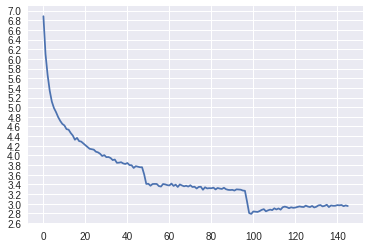

In [0]:
trainIters(encoder, decoder, encoder_optimizer, decoder_optimizer, n_iters, teacher_forcing_ratio, print_every=100, plot_every=100, learning_rate=learning_rate)

In [0]:
torch.save(encoder.state_dict(), folder_path + 'encoder_1210_new.pt')
torch.save(decoder.state_dict(), folder_path + 'decoder_1210_new.pt')

In [0]:
decoded, actual = evaluate_batch(val_loader, encoder, decoder)

for i in zip(decoded, actual):
    if i == 10:
        break
    print('\n')
    print('Expected:', i[1])
    print('Actual:' ,i[0])



Expected:  She retired two years ago only to turn our house into a school for girls and women in our neighborhood .
Actual:  She was years old and she was a member of a child in the school of the school .


Expected:  There was a big smile on his face which was unusual then because the news mostly depressed him .
Actual:  He was so sad that his face was not very sad because he was a very sad story .


Expected:  And my father that s him he was the first ever in his family to receive an education .
Actual:  And my father was one of the most prolific and his family .


Expected:  We all knew we were risking our lives the teacher the students and our parents .
Actual:  We all know that the kids are very hard to tell us that they are very very hard to tell the story .


Expected:  When I was I remember waking up one morning to the sound of joy in my house .
Actual:  I remember when I was born I was born in the morning .


Expected:  I didn t know what it meant but I could see that my fat

In [0]:
evaluate_bleu(decoded,actual)

5.456579716228199

In [0]:
# Configure models
hidden_size = 500
layers = 1
teacher_forcing_ratio = 1.0
learning_rate = 0.0005
decoder_learning_ratio = 2.0
n_iters = 10000


# Initialize models
encoder = EncoderRNN(weights_matrix_zh, train_input_lang.n_words, hidden_size, n_layers = layers).to(device)
decoder = DecoderRNN(weights_matrix_eng, hidden_size, train_output_lang.n_words, n_layers = layers).to(device)

# Initialize optimizers and criterion
encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)

encoder.load_state_dict(torch.load(folder_path + "encoder_1210_new.pt"))
decoder.load_state_dict(torch.load(folder_path +"decoder_1210_new.pt"))

In [0]:
trainIters(encoder, decoder, encoder_optimizer, decoder_optimizer, n_iters, teacher_forcing_ratio, print_every=100, plot_every=100, learning_rate=learning_rate)

1m 12s (- 120m 5s) (100 1%) 2.4887
2m 26s (- 119m 48s) (200 2%) 2.4670
3m 40s (- 118m 53s) (300 3%) 2.4992
4m 54s (- 117m 50s) (400 4%) 2.4401
6m 8s (- 116m 49s) (500 5%) 2.4673
7m 22s (- 115m 38s) (600 6%) 2.4783
8m 36s (- 114m 27s) (700 7%) 2.4424
9m 50s (- 113m 15s) (800 8%) 2.4557
